### Data Loader

In [52]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.dates import date2num

def download_stock_data(ticker: str, start_date: str, end_date: str) -> pd.DataFrame:
    data = yf.download(ticker, start=start_date, end=end_date)
    data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
    data.dropna(inplace=True)
    return data

### Preprocessing

In [53]:

def add_target(data: pd.DataFrame) -> pd.DataFrame:
    data['Target'] = np.where(data['Close'].shift(-1) > data['Close'], 1, 0)
    return data

def create_features(data: pd.DataFrame, sequence_length: int = 60):
    features = []
    targets = []
    for i in range(len(data) - sequence_length):
        features.append(data.iloc[i:i+sequence_length].loc[:, data.columns != 'Target'].values)
        targets.append(data.iloc[i+sequence_length]['Target'])
    return np.array(features), np.array(targets)

def scale_features(data: pd.DataFrame):
    scaler = StandardScaler()
    scaled_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)
    return scaled_data, scaler


### Plotting

In [54]:
def plot_price_and_volume(df, ticker='Stock'):
    dates   = date2num(df.index.to_pydatetime())
    close   = df['Close'].astype(float).values
    volume  = df['Volume'].astype(float).values

    # Flatten volume if it's 2D
    if volume.ndim > 1:
        volume = volume.flatten()

    # Ensure same length
    min_len = min(len(dates), len(volume))
    dates = dates[:min_len]
    close = close[:min_len]
    volume = volume[:min_len]

    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax1.set_title(f"{ticker} – Close & Volume")
    ax1.plot(df.index[:min_len], close)
    ax1.set_ylabel('Close')

    ax2 = ax1.twinx()
    ax2.bar(dates, volume,
            width=1.0,
            alpha=0.3,
            linewidth=0,
            edgecolor='none')
    ax2.set_ylabel('Volume')
    ax2.xaxis_date()

    ax1.grid(True)
    fig.tight_layout()
    plt.show()

### Downloading and preparing sequences for AAPL

[*********************100%***********************]  1 of 1 completed
C:\Users\Baile\AppData\Local\Temp\ipykernel_17904\1607731215.py:4: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_scaled, scaler = scale_features(df.drop(columns=['Target']))


X shape: (2204, 60, 6), y shape: (2204, 1)


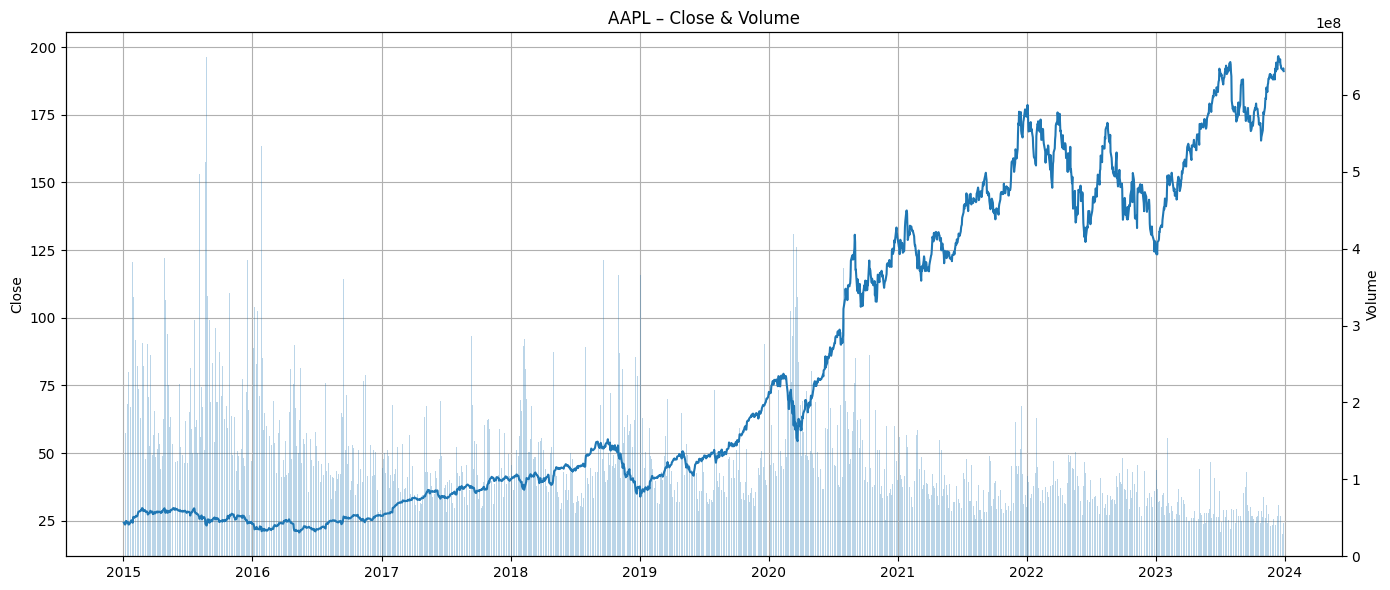

In [55]:
# Download and prepare data
df = download_stock_data('AAPL', '2015-01-01', '2023-12-31')
df = add_target(df)
df_scaled, scaler = scale_features(df.drop(columns=['Target']))
df_scaled['Target'] = df['Target']  # Add target back

# Create LSTM-ready sequences
X, y = create_features(df_scaled, sequence_length=60)

print(f"X shape: {X.shape}, y shape: {y.shape}")

plot_price_and_volume(df, 'AAPL')